# CP_Reach Structured Nonlinear Workflow

This notebook demonstrates reachability analysis for **nonlinear** systems using the workflow:

```
Modelica Models -> Rumoca (compile) -> DAE JSON -> CP_Reach (analyze)
```

**Key feature**: For nonlinear systems, we use time-varying polytopic LMI bounds:
1. Compute the Jacobian of the error dynamics along the reference trajectory
2. Create polytopic bounds on the Jacobian (e.g., for sin(theta) nonlinearity)
3. Solve a time-varying LMI with polynomial Lyapunov function M(t)

**Important**: Make sure to select the `lie` kernel before running this notebook.

In [23]:
# =============================================================================
# CONFIGURATION (matching paper Table I)
# =============================================================================

MODELICA_FILE = "models/pendulum_closed_loop.mo"
MODEL_NAME = "PendulumClosedLoop"
OUTPUT_DIR = "output_nonlinear"
RUMOCA_BIN = "/home/micah/Research/dev2/rumoca/target/debug/rumoca"

# Disturbance bounds (paper: w̄ = 0.1 Nm)
DISTURBANCE_BOUNDS = {"d": 0.1}

# Polytopic bound: assumed error in theta for Jacobian linearization
ERR_THETA_BOUND = 0.1  # radians

In [24]:
import subprocess
import os
from pathlib import Path
import numpy as np
import sympy as sp
from scipy.optimize import fminbound

os.makedirs(OUTPUT_DIR, exist_ok=True)
dae_json_path = Path(OUTPUT_DIR) / f"{MODEL_NAME.lower()}.json"

# Compile with Rumoca
cmd = [RUMOCA_BIN, "--json", "-m", MODEL_NAME, MODELICA_FILE]
print(f"Running: {' '.join(cmd)}")
result = subprocess.run(cmd, capture_output=True, text=True)
if result.returncode != 0:
    raise RuntimeError(f"Rumoca failed: {result.stderr}")
with open(dae_json_path, "w") as f:
    f.write(result.stdout)
print(f"Wrote {dae_json_path}")

Running: /home/micah/Research/dev2/rumoca/target/debug/rumoca --json -m PendulumClosedLoop models/pendulum_closed_loop.mo
Wrote output_nonlinear/pendulumclosedloop.json


In [46]:
! pip install rumoca


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.9/632.9 kB 10.9 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for rumoca: filename=rumoca-0.7.28-cp313-cp313-linux_x86_64.whl size=1714955 sha256=dc0183f384a5d8c7007e845bab96c68b0582c091b6b56abe098af1016aeffd76
  Stored in directory: /home/micah/.cache/pip/wheels/4e/2f/91/bce7e525067cf7b2f7e9659e9644173e99aea76d120b158e5c
Successfully built rumoca


In [48]:
import rumoca
result = rumoca.compile("models/pendulum_closed_loop.mo")
json_str = result.to_base_modelica_json()

In [51]:
ir = DaeIR.from_json_str(json_str)

## Load Model

In [25]:
from cp_reach.ir import DaeIR, ir_to_symbolic_statespace
from cp_reach.dynamics.classification import DynamicsClass

# Load IR and convert to symbolic state space
ir = DaeIR.from_json(str(dae_json_path))
ss = ir_to_symbolic_statespace(ir)

print("States:", ss.get_state_names())
print("Inputs:", ss.get_input_names())
print("Parameters:", ir.get_param_defaults())

# Display the drift dynamics to see the sin(theta) term
print("\nDrift dynamics f(x,p,t):")
sp.pprint(ss.f)

# Classify based on whether error dynamics are linear
# (This checks if Jacobian J = ∂f/∂x depends on state)
disturbance_inputs = ['d']
error_is_linear = ss.error_dynamics_are_linear(disturbance_inputs=disturbance_inputs)
model_type = DynamicsClass.LINEAR if error_is_linear else DynamicsClass.NONLINEAR

print(f"\nError dynamics classification: {model_type}")

States: ['theta', 'omega', 'xi']
Inputs: ['theta_ref', 'omega_ref', 'alpha_ref', 'u_ff', 'd']
Parameters: {'m': 1.0, 'l': 1.0, 'g': 9.81, 'c': 0.1, 'Kp': 5.0, 'Ki': 1.0, 'Kd': 0.5}

Drift dynamics f(x,p,t):
⎡                   ω                    ⎤
⎢                                        ⎥
⎢-Kd⋅ω + Ki⋅ξ - Kp⋅θ - c⋅ω - g⋅l⋅m⋅sin(θ)⎥
⎢────────────────────────────────────────⎥
⎢                   2                    ⎥
⎢                  l ⋅m                  ⎥
⎢                                        ⎥
⎣                   -θ                   ⎦

Error dynamics classification: DynamicsClass.NONLINEAR


## Compute Error Dynamics

For nonlinear systems, the error dynamics are also nonlinear. We compute them symbolically.

In [26]:
# Compute symbolic error dynamics
# For e = x - x_ref, the error dynamics are: ė = J(x)*e + B_d*d
# where J = ∂f/∂x is the Jacobian and B_d = ∂f/∂d is the disturbance matrix
error_dyn = ss.get_error_dynamics(disturbance_inputs=disturbance_inputs)

print("Error dynamics components:")
print(f"\nJacobian J = ∂f/∂x (determines if error dynamics are linear):")
sp.pprint(error_dyn['J'])
print(f"\nDisturbance matrix B_d = ∂f/∂d:")
sp.pprint(error_dyn['B_d'])

# Store for later use
J_sym = error_dyn['J']
B_d_sym = error_dyn['B_d']

Error dynamics components:

Jacobian J = ∂f/∂x (determines if error dynamics are linear):
⎡        0              1      0  ⎤
⎢                                 ⎥
⎢-Kp - g⋅l⋅m⋅cos(θ)  -Kd - c   Ki ⎥
⎢──────────────────  ───────  ────⎥
⎢        2             2       2  ⎥
⎢       l ⋅m          l ⋅m    l ⋅m⎥
⎢                                 ⎥
⎣        -1             0      0  ⎦

Disturbance matrix B_d = ∂f/∂d:
⎡ 0  ⎤
⎢    ⎥
⎢ 1  ⎥
⎢────⎥
⎢ 2  ⎥
⎢l ⋅m⎥
⎢    ⎥
⎣ 0  ⎦


In [27]:
# The error_is_linear was already computed in cell-4
print(f"Error dynamics are: {'LINEAR' if error_is_linear else 'NONLINEAR'}")

if error_is_linear:
    print("\nThe Jacobian J is constant - can use standard LMI.")
else:
    print("\nThe Jacobian J depends on state (contains sin(theta) or cos(theta)).")
    print("Must use time-varying polytopic LMI bounds.")

Error dynamics are: NONLINEAR

The Jacobian J depends on state (contains sin(theta) or cos(theta)).
Must use time-varying polytopic LMI bounds.


## Extract Symbolic Jacobian and Disturbance Matrix

For the polytopic LMI, we need:
- J(x) = ∂f/∂x (state Jacobian, depends on theta)
- B = disturbance input matrix (constant for this system)

In [28]:
# Substitute parameters into J and B_d for numerical evaluation
param_values = ir.get_param_defaults()
param_subs = {sp.Symbol(k): v for k, v in param_values.items()}

# J_sym still contains state symbols (theta) - that's the nonlinearity
J_sym_with_params = J_sym.subs(param_subs)
print("Jacobian J(x) with parameters substituted:")
sp.pprint(J_sym_with_params)

# B_d is constant after parameter substitution
B_d = np.array(B_d_sym.subs(param_subs), dtype=float)
print(f"\nDisturbance matrix B_d (numerical):")
print(B_d)

Jacobian J(x) with parameters substituted:
⎡        0            1     0 ⎤
⎢                             ⎥
⎢-9.81⋅cos(θ) - 5.0  -0.6  1.0⎥
⎢                             ⎥
⎣        -1           0     0 ⎦

Disturbance matrix B_d (numerical):
[[0.]
 [1.]
 [0.]]


## Generate Reference Trajectory

Use polynomial path planning to generate a smooth pendulum swing trajectory.

In [29]:
from cp_reach.planning import plan_minimum_derivative_trajectory

# Reference trajectory matching paper Section V-A:
# Two-segment plan: 0 → π/4 → 0 with T0 = T1 = 2s
# Using minimum-jerk quintic interpolation with rest boundary conditions

# Segment 1: 0 → π/4
bc1 = np.array([
    [[0.0], [np.pi/4]],   # theta: start=0, end=π/4 rad
    [[0.0], [0.0]],       # omega: start=0, end=0
    [[0.0], [0.0]],       # alpha: start=0, end=0
])

# Segment 2: π/4 → 0
bc2 = np.array([
    [[np.pi/4], [0.0]],   # theta: start=π/4, end=0 rad
    [[0.0], [0.0]],       # omega: start=0, end=0
    [[0.0], [0.0]],       # alpha: start=0, end=0
])

# Plan each segment (T = 2s each)
ref_traj1 = plan_minimum_derivative_trajectory(
    bc=bc1, min_deriv=3, poly_deg=5,
    T_guess=np.array([2.0]), bc_deriv=3,
)
ref_traj2 = plan_minimum_derivative_trajectory(
    bc=bc2, min_deriv=3, poly_deg=5,
    T_guess=np.array([2.0]), bc_deriv=3,
)

# Concatenate trajectories
t_eval = np.concatenate([ref_traj1.t, ref_traj1.t[-1] + ref_traj2.t[1:]])
theta_ref_traj = np.concatenate([ref_traj1.x[:, 0], ref_traj2.x[1:, 0]])
omega_ref_traj = np.concatenate([
    ref_traj1.metadata['derivatives']['vel'][:, 0],
    ref_traj2.metadata['derivatives']['vel'][1:, 0]
])
alpha_ref_traj = np.concatenate([
    ref_traj1.metadata['derivatives']['acc'][:, 0],
    ref_traj2.metadata['derivatives']['acc'][1:, 0]
])

print(f"Reference trajectory: t=[0, {t_eval[-1]:.1f}]s (two segments of 2s each)")
print(f"  theta_ref: {theta_ref_traj[0]:.3f} → {np.max(theta_ref_traj):.3f} → {theta_ref_traj[-1]:.3f} rad")
print(f"  (0 → π/4 → 0)")

Reference trajectory: t=[0, 4.0]s (two segments of 2s each)
  theta_ref: 0.000 → 0.785 → -0.000 rad
  (0 → π/4 → 0)


## Compute Time-Varying Polytopic LMI Bounds

For nonlinear systems, we:
1. Sample the reference trajectory at k time points
2. At each point, create polytopic bounds on the Jacobian (for ±err_theta)
3. Solve for a polynomial Lyapunov function M(t) = Σ t^r M_r

In [30]:
# Import polytopic LMI functions from library
from cp_reach.reachability import (
    polytopic_jacobians,
    solve_time_varying_polytopic_lmi,
    eval_polynomial_metric,
    project_metric_2d,
    compute_state_bounds,
)

print("Imported polytopic LMI functions from cp_reach.reachability")

Imported polytopic LMI functions from cp_reach.reachability


In [31]:
# Number of sample points for the time-varying LMI
# More samples = tighter constraint enforcement, but higher computational cost
# Using 20 samples for better accuracy (10 samples can cause ~3% bound violations)
num_samples = 20

# Get sample indices
idx = np.round(np.linspace(0, len(t_eval) - 1, num_samples)).astype(int)
times = [t_eval[i] for i in idx]
theta_ref_samples = [theta_ref_traj[i] for i in idx]

print(f"Sampling {num_samples} points along trajectory")
print(f"Times: {[f'{t:.2f}' for t in times]}")
print(f"Theta_ref: {[f'{th:.3f}' for th in theta_ref_samples]}")

# Get polytopic Jacobian bounds at each sample point
# Use J_sym_with_params which has parameters substituted but still contains theta
err_theta = ERR_THETA_BOUND
jacobian_polytopes = polytopic_jacobians(
    J_sym_with_params, theta_ref_samples, err_theta, ss.state_symbols
)

print(f"\nPolytopic bounds: theta_ref ± {err_theta} rad")
print(f"Created {len(jacobian_polytopes)} polytopes with {len(jacobian_polytopes[0])} vertices each")

Sampling 20 points along trajectory
Times: ['0.00', '0.20', '0.42', '0.63', '0.85', '1.05', '1.27', '1.47', '1.68', '1.90', '2.10', '2.32', '2.53', '2.73', '2.95', '3.15', '3.37', '3.58', '3.80', '4.00']
Theta_ref: ['0.000', '0.007', '0.053', '0.142', '0.283', '0.430', '0.584', '0.693', '0.760', '0.784', '0.784', '0.760', '0.693', '0.584', '0.430', '0.283', '0.142', '0.053', '0.007', '-0.000']

Polytopic bounds: theta_ref ± 0.1 rad
Created 20 polytopes with 2 vertices each


In [32]:
# Solve the polytopic LMI using the library function
print("Solving time-varying polytopic LMI...")

lmi_result = solve_time_varying_polytopic_lmi(
    jacobian_polytopes, B_d, times, polynomial_degree=num_samples, verbose=True
)

if lmi_result["status"] == "infeasible":
    raise RuntimeError("No feasible LMI solution found")

# Extract results
M_coefs_val = lmi_result["M_coefs"]
mu_star = lmi_result["mu"]
mu_phys = lmi_result["mu_physical"]
alpha_star = lmi_result["alpha"]

print(f"\nLMI solution status: {lmi_result['status']}")

Solving time-varying polytopic LMI...
Searching for optimal alpha...


/home/micah/miniconda3/envs/lie/lib/python3.13/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Optimal alpha: 0.9361
Optimal mu (normalized): 1.039608e+01
Optimal mu (physical): 2.599021e+00

LMI solution status: optimal_inaccurate


In [33]:
# Compute per-state bounds using the library function
dist_bound = DISTURBANCE_BOUNDS['d']
T_phys = times[-1] - times[0]

bounds_result = compute_state_bounds(M_coefs_val, mu_phys, dist_bound, times)
bounds_upper = bounds_result["bounds_max"]
c = bounds_result["c"]

print(f"Physical time horizon T = {T_phys:.1f} s")
print(f"mu (normalized) = {mu_star:.6e}")
print(f"mu_phys = mu/T = {mu_phys:.6e}")
print(f"c = mu_phys * w̄² = {c:.6e}")
print(f"\nTime-varying bounds (max over trajectory):")
print(f"  theta: ±{bounds_upper[0]:.6f} rad ({np.degrees(bounds_upper[0]):.4f} deg)")
print(f"  omega: ±{bounds_upper[1]:.6f} rad/s")
print(f"  xi:    ±{bounds_upper[2]:.6f} rad*s")

# CRITICAL: Validate polytopic assumption
# The LMI is only valid if the computed theta bound ≤ ERR_THETA_BOUND
if bounds_upper[0] > ERR_THETA_BOUND:
    print(f"\n⚠️  WARNING: Computed theta bound ({bounds_upper[0]:.4f}) > polytopic assumption ({ERR_THETA_BOUND})")
    print(f"    The LMI bounds may not be valid! Consider increasing ERR_THETA_BOUND.")
else:
    print(f"\n✓ Polytopic assumption validated: theta bound ({bounds_upper[0]:.4f}) ≤ ERR_THETA_BOUND ({ERR_THETA_BOUND})")

Physical time horizon T = 4.0 s
mu (normalized) = 1.039608e+01
mu_phys = mu/T = 2.599021e+00
c = mu_phys * w̄² = 2.599021e-02

Time-varying bounds (max over trajectory):
  theta: ±0.045399 rad (2.6012 deg)
  omega: ±0.161462 rad/s
  xi:    ±0.161134 rad*s

✓ Polytopic assumption validated: theta bound (0.0454) ≤ ERR_THETA_BOUND (0.1)


## Simulate with Systematic Disturbance Sweep

Build a numerical dynamics function and simulate with square-wave disturbances at systematically varied frequencies and phases.

In [34]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

# Build numerical dynamics function from symbolic model
full_dynamics = ss.f + ss.Bu
dynamics_with_params = full_dynamics.subs(param_subs)

# Create lambda function for dynamics
state_syms = ss.state_symbols
input_syms = ss.input_symbols
dynamics_func = sp.lambdify(
    [state_syms, input_syms], 
    dynamics_with_params, 
    modules='numpy'
)

# Create reference interpolators
theta_ref_interp = interp1d(t_eval, theta_ref_traj, fill_value='extrapolate')
omega_ref_interp = interp1d(t_eval, omega_ref_traj, fill_value='extrapolate')
alpha_ref_interp = interp1d(t_eval, alpha_ref_traj, fill_value='extrapolate')

# Get parameter values
m_val = param_values['m']
l_val = param_values['l']
g_val = param_values['g']
c_val = param_values['c']
Kd_val = param_values['Kd']  # Need Kd for proper feedforward

def get_inputs(t, d_val=0.0):
    """Get input vector [theta_ref, omega_ref, alpha_ref, u_ff, d] at time t
    
    The feedforward u_ff compensates for the nominal dynamics:
    u_ff = m*l^2*alpha_ref + (c + Kd)*omega_ref + m*g*l*sin(theta_ref)
    
    This ensures perfect tracking when theta=theta_ref, omega=omega_ref.
    """
    theta_ref = float(theta_ref_interp(t))
    omega_ref = float(omega_ref_interp(t))
    alpha_ref = float(alpha_ref_interp(t))
    # Feedforward: u_ff = m*l^2*alpha_ref + (c + Kd)*omega_ref + m*g*l*sin(theta_ref)
    # The (c + Kd) term compensates for both damping and derivative feedback
    u_ff = (m_val * l_val**2 * alpha_ref + 
            (c_val + Kd_val) * omega_ref + 
            m_val * g_val * l_val * np.sin(theta_ref))
    return [theta_ref, omega_ref, alpha_ref, u_ff, d_val]

print(f"Dynamics function created from symbolic model")
print(f"States: {[str(s) for s in state_syms]}")
print(f"Inputs: {[str(s) for s in input_syms]}")
print(f"Feedforward includes Kd={Kd_val} compensation")

Dynamics function created from symbolic model
States: ['theta', 'omega', 'xi']
Inputs: ['theta_ref', 'omega_ref', 'alpha_ref', 'u_ff', 'd']
Feedforward includes Kd=0.5 compensation


In [35]:
# Systematic sweep over frequency and phase for square-wave disturbances
# Paper Section V-C: frequencies f ∈ {0.1, 0.2, ..., 0.9} Hz
dist_bound = DISTURBANCE_BOUNDS['d']
t_span = (t_eval[0], t_eval[-1])
x0 = [theta_ref_traj[0], omega_ref_traj[0], 0.0]  # Start on reference, xi=0

# Frequency grid matching paper (0.1-0.9 Hz)
frequencies = np.arange(0.1, 1.0, 0.1)  # 9 frequencies: 0.1, 0.2, ..., 0.9 Hz
n_phases = 10  # 10 phase values per frequency

print(f"Sweeping {len(frequencies)} frequencies × {n_phases} phases = {len(frequencies) * n_phases} simulations")
print(f"Frequencies: {frequencies} Hz")

state_trajectories = []
error_trajectories = []

# Nominal trajectory (no disturbance)
def nominal_ode(t, state):
    inputs = get_inputs(t, d_val=0.0)
    return np.array(dynamics_func(state, inputs)).flatten()

nom_sol = solve_ivp(nominal_ode, t_span, x0, t_eval=t_eval, method='RK45')
nom_theta, nom_omega, nom_xi = nom_sol.y[0], nom_sol.y[1], nom_sol.y[2]
nom_e_theta = nom_theta - theta_ref_traj
nom_e_omega = nom_omega - omega_ref_traj

# Systematic sweep over frequency and phase
# Square wave saturates magnitude bound for longest time → adversarial choice
for freq in frequencies:
    period = 1.0 / freq
    phases = np.linspace(0, period, n_phases, endpoint=False)
    
    for phase in phases:
        def square_wave_disturbance(t, period=period, phase=phase):
            t_shifted = t + phase
            cycle_pos = (t_shifted % period) / period
            return dist_bound if cycle_pos < 0.5 else -dist_bound
        
        def disturbed_ode(t, state):
            d_val = square_wave_disturbance(t)
            inputs = get_inputs(t, d_val=d_val)
            return np.array(dynamics_func(state, inputs)).flatten()
        
        sol_ode = solve_ivp(disturbed_ode, t_span, x0, t_eval=t_eval, method='RK45')
        theta_traj, omega_traj, xi_traj = sol_ode.y[0], sol_ode.y[1], sol_ode.y[2]
        e_theta = theta_traj - theta_ref_traj
        e_omega = omega_traj - omega_ref_traj
        
        state_trajectories.append(np.array([theta_traj, omega_traj, xi_traj]))
        error_trajectories.append(np.array([e_theta, e_omega, xi_traj]))

print(f"Completed {len(error_trajectories)} simulations")

Sweeping 9 frequencies × 10 phases = 90 simulations
Frequencies: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9] Hz
Completed 90 simulations


## Plot State Trajectories with Flowpipe

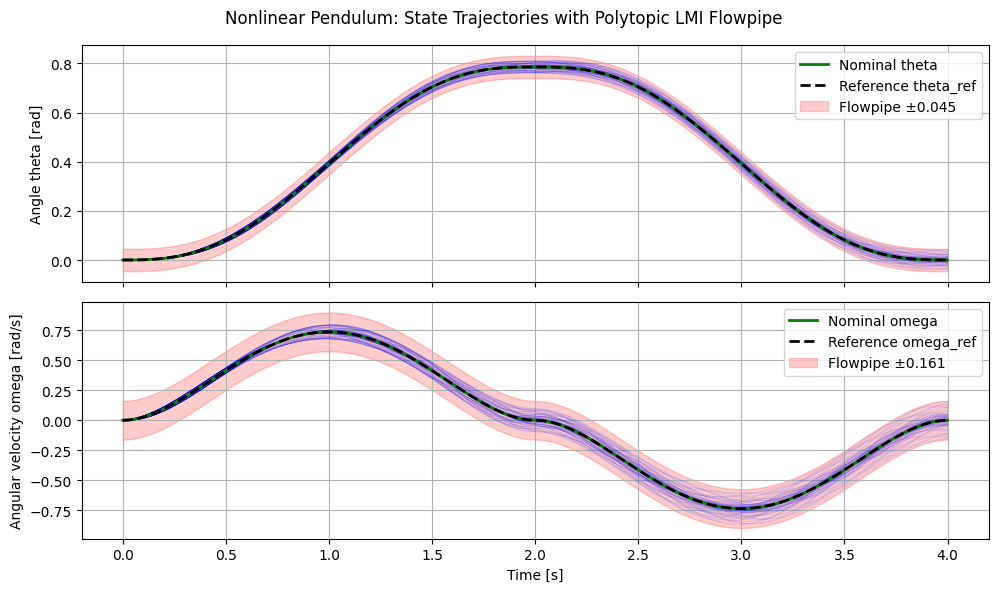

In [36]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot theta with flowpipe
ax = axes[0]
for traj in state_trajectories:
    ax.plot(t_eval, traj[0], 'b-', alpha=0.1, linewidth=0.5)
ax.plot(t_eval, nom_theta, 'g-', linewidth=2, label='Nominal theta')
ax.plot(t_eval, theta_ref_traj, 'k--', linewidth=2, label='Reference theta_ref')
# Flowpipe bounds around reference
ax.fill_between(t_eval, theta_ref_traj - bounds_upper[0], theta_ref_traj + bounds_upper[0], 
                color='r', alpha=0.2, label=f'Flowpipe ±{bounds_upper[0]:.3f}')
ax.set_ylabel('Angle theta [rad]')
ax.legend(loc='upper right')
ax.grid(True)

# Plot omega with flowpipe
ax = axes[1]
for traj in state_trajectories:
    ax.plot(t_eval, traj[1], 'b-', alpha=0.1, linewidth=0.5)
ax.plot(t_eval, nom_omega, 'g-', linewidth=2, label='Nominal omega')
ax.plot(t_eval, omega_ref_traj, 'k--', linewidth=2, label='Reference omega_ref')
# Flowpipe bounds around reference
ax.fill_between(t_eval, omega_ref_traj - bounds_upper[1], omega_ref_traj + bounds_upper[1], 
                color='r', alpha=0.2, label=f'Flowpipe ±{bounds_upper[1]:.3f}')
ax.set_ylabel('Angular velocity omega [rad/s]')
ax.set_xlabel('Time [s]')
ax.legend(loc='upper right')
ax.grid(True)

fig.suptitle('Nonlinear Pendulum: State Trajectories with Polytopic LMI Flowpipe')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/state_flowpipe.png", dpi=150)
plt.show()

## Plot Error Trajectories

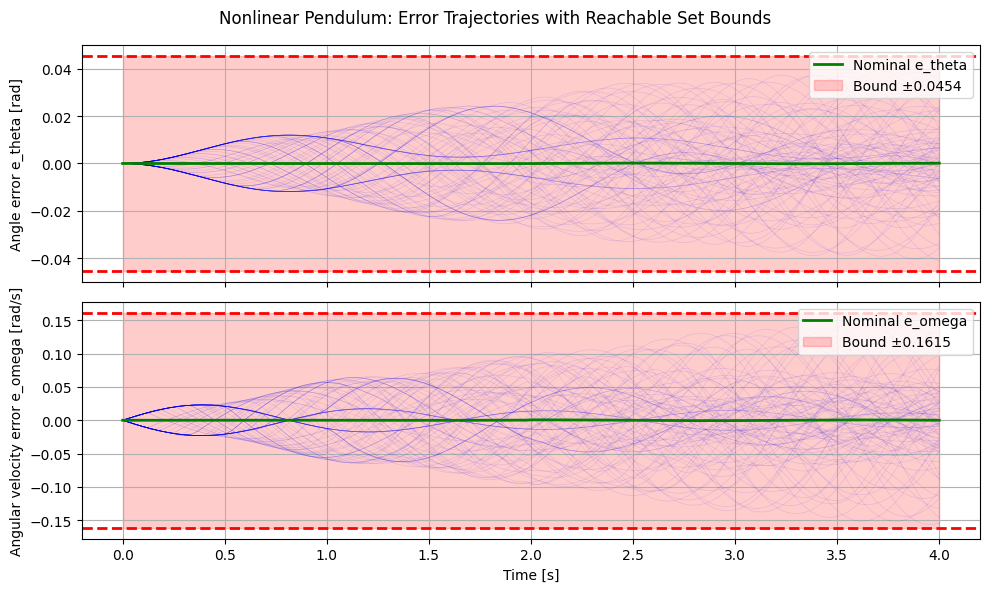


Validation - Maximum observed errors vs LMI bounds:
  e_theta: max = 0.041502, bound = 0.045399
  e_omega: max = 0.157567, bound = 0.161462

✓ All simulated trajectories stay within computed LMI bounds!


In [37]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot theta error
ax = axes[0]
for traj in error_trajectories:
    ax.plot(t_eval, traj[0], 'b-', alpha=0.1, linewidth=0.5)
ax.plot(t_eval, nom_e_theta, 'g-', linewidth=2, label='Nominal e_theta')
ax.axhline(bounds_upper[0], color='r', linestyle='--', linewidth=2)
ax.axhline(-bounds_upper[0], color='r', linestyle='--', linewidth=2)
ax.fill_between(t_eval, -bounds_upper[0], bounds_upper[0], color='r', alpha=0.2, 
                label=f'Bound ±{bounds_upper[0]:.4f}')
ax.set_ylabel('Angle error e_theta [rad]')
ax.legend(loc='upper right')
ax.grid(True)

# Plot omega error
ax = axes[1]
for traj in error_trajectories:
    ax.plot(t_eval, traj[1], 'b-', alpha=0.1, linewidth=0.5)
ax.plot(t_eval, nom_e_omega, 'g-', linewidth=2, label='Nominal e_omega')
ax.axhline(bounds_upper[1], color='r', linestyle='--', linewidth=2)
ax.axhline(-bounds_upper[1], color='r', linestyle='--', linewidth=2)
ax.fill_between(t_eval, -bounds_upper[1], bounds_upper[1], color='r', alpha=0.2,
                label=f'Bound ±{bounds_upper[1]:.4f}')
ax.set_ylabel('Angular velocity error e_omega [rad/s]')
ax.set_xlabel('Time [s]')
ax.legend(loc='upper right')
ax.grid(True)

fig.suptitle('Nonlinear Pendulum: Error Trajectories with Reachable Set Bounds')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/error_trajectories.png", dpi=150)
plt.show()

# Validation: Compare max errors vs computed bounds
max_e_theta = max(np.max(np.abs(traj[0])) for traj in error_trajectories)
max_e_omega = max(np.max(np.abs(traj[1])) for traj in error_trajectories)

print(f"\nValidation - Maximum observed errors vs LMI bounds:")
print(f"  e_theta: max = {max_e_theta:.6f}, bound = {bounds_upper[0]:.6f}")
print(f"  e_omega: max = {max_e_omega:.6f}, bound = {bounds_upper[1]:.6f}")

# Check if bounds are valid
theta_valid = max_e_theta <= bounds_upper[0] * 1.01  # 1% tolerance for numerical noise
omega_valid = max_e_omega <= bounds_upper[1] * 1.01

if theta_valid and omega_valid:
    print(f"\n✓ All simulated trajectories stay within computed LMI bounds!")
else:
    print(f"\n⚠️  Some trajectories exceed bounds:")
    if not theta_valid:
        print(f"    e_theta exceeds bound by {(max_e_theta/bounds_upper[0] - 1)*100:.1f}%")
    if not omega_valid:
        print(f"    e_omega exceeds bound by {(max_e_omega/bounds_upper[1] - 1)*100:.1f}%")
    print(f"    Check: polytopic assumption ERR_THETA_BOUND = {ERR_THETA_BOUND} vs computed bound = {bounds_upper[0]:.4f}")

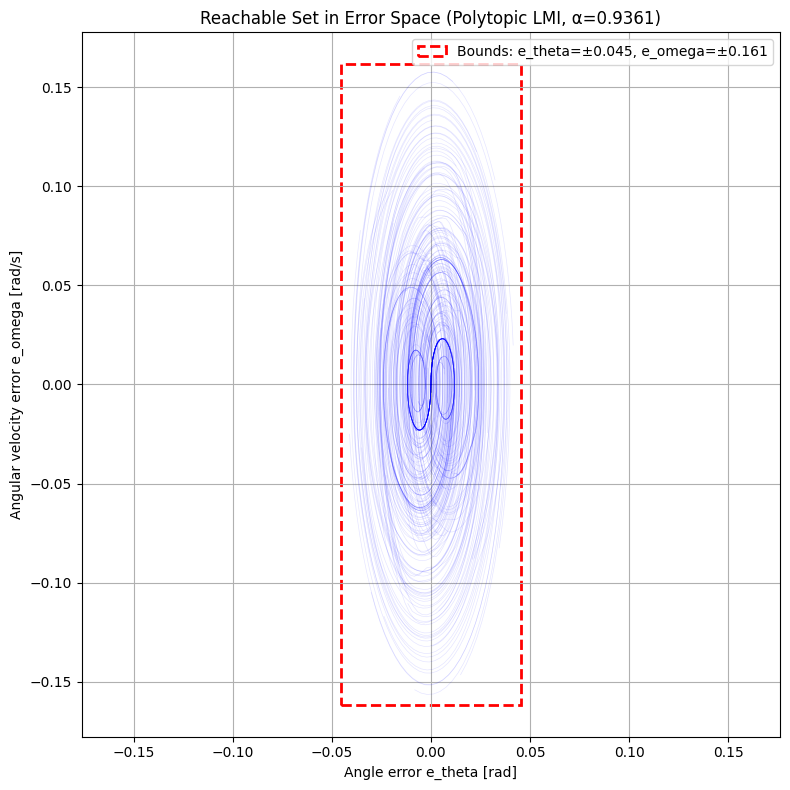

In [38]:
# 2D phase plot in error space
fig, ax = plt.subplots(figsize=(8, 8))

# Plot Monte Carlo error trajectories
for traj in error_trajectories:
    ax.plot(traj[0], traj[1], 'b-', alpha=0.1, linewidth=0.5)

# Plot bounding box
r_theta, r_omega = bounds_upper[0], bounds_upper[1]
rect = plt.Rectangle((-r_theta, -r_omega), 2*r_theta, 2*r_omega, fill=False, 
                    edgecolor='r', linestyle='--', linewidth=2,
                    label=f'Bounds: e_theta=±{r_theta:.3f}, e_omega=±{r_omega:.3f}')
ax.add_patch(rect)

ax.set_xlabel('Angle error e_theta [rad]')
ax.set_ylabel('Angular velocity error e_omega [rad/s]')
ax.set_title(f'Reachable Set in Error Space (Polytopic LMI, α={alpha_star:.4f})')
ax.legend()
ax.axis('equal')
ax.grid(True)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/error_phase.png", dpi=150)
plt.show()

## Time-Varying Metric Space Visualization

Transform error trajectories into the time-varying metric space where the invariant set becomes a unit ball. This visualization shows that all trajectories stay within the certified bounds.

In [39]:
# Import plotting utilities from library
from cp_reach.plotting.plotting import plot_ellipse

print("Imported plot_ellipse from cp_reach.plotting")

Imported plot_ellipse from cp_reach.plotting


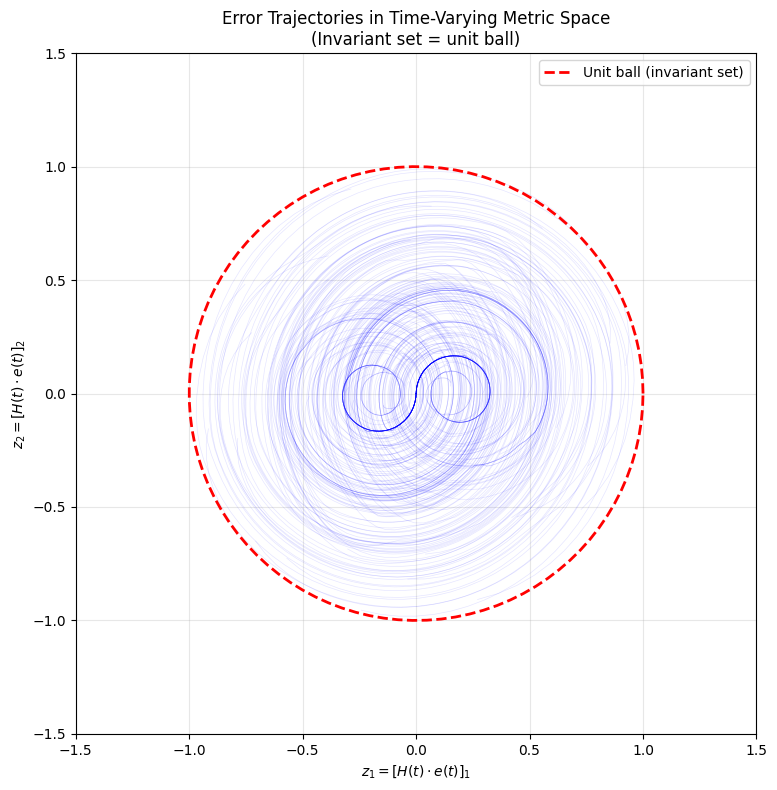


Maximum radius in metric space: 1.0102
  at time t = 3.92s, trajectory 50
Unit ball radius: 1.0
⚠️  Trajectories exceed unit ball by 1.0%
   Note: The LMI is enforced at 20 discrete sample points.
   Use continuous-time certification (Algorithm 2) for rigorous guarantees.


In [40]:
# Plot error trajectories in time-varying metric space
# Transform e(t) -> z(t) = H(t) @ e(t) where M(t) = H(t)^T @ H(t)
# In this space, the invariant set becomes the unit ball

fig, ax = plt.subplots(figsize=(8, 8))

dist = DISTURBANCE_BOUNDS['d']

# Transform and plot each error trajectory
for traj in error_trajectories:
    e_theta = traj[0]  # (T,)
    e_omega = traj[1]  # (T,)
    e = np.vstack([e_theta, e_omega])  # (2, T)
    
    T_pts = e.shape[1]
    z = np.zeros((2, T_pts))
    
    for i, ti in enumerate(t_eval):
        # Get M(t) and project to theta-omega subspace
        M_t = eval_polynomial_metric(M_coefs_val, ti, times)
        M_t = 0.5 * (M_t + M_t.T) / (mu_phys * dist**2)  # symmetrize + normalize
        M_proj = project_metric_2d(M_t, indices=(0, 1))
        
        # Cholesky decomposition: M = L @ L.T, so H = L.T
        L = np.linalg.cholesky(M_proj)
        H_t = L.T
        
        # Transform error to metric space
        z[:, i] = H_t @ e[:, i]
    
    ax.plot(z[0, :], z[1, :], 'b-', alpha=0.1, linewidth=0.5)

# Plot the unit circle (invariant set in metric space)
theta_circle = np.linspace(0, 2*np.pi, 100)
ax.plot(np.cos(theta_circle), np.sin(theta_circle), 'r--', linewidth=2, label='Unit ball (invariant set)')

ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel(r'$z_1 = [H(t) \cdot e(t)]_1$')
ax.set_ylabel(r'$z_2 = [H(t) \cdot e(t)]_2$')
ax.set_title('Error Trajectories in Time-Varying Metric Space\n(Invariant set = unit ball)')
ax.legend()
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/metric_space.png", dpi=150)
plt.show()

# Compute maximum radius in metric space
max_radius = 0
max_radius_time = 0
max_radius_traj_idx = 0
for traj_idx, traj in enumerate(error_trajectories):
    e_theta = traj[0]
    e_omega = traj[1]
    e = np.vstack([e_theta, e_omega])
    
    for i, ti in enumerate(t_eval):
        M_t = eval_polynomial_metric(M_coefs_val, ti, times)
        M_t = 0.5 * (M_t + M_t.T) / (mu_phys * dist**2)
        M_proj = project_metric_2d(M_t, indices=(0, 1))
        L = np.linalg.cholesky(M_proj)
        H_t = L.T
        z = H_t @ e[:, i]
        radius = np.linalg.norm(z)
        if radius > max_radius:
            max_radius = radius
            max_radius_time = ti
            max_radius_traj_idx = traj_idx

print(f"\nMaximum radius in metric space: {max_radius:.4f}")
print(f"  at time t = {max_radius_time:.2f}s, trajectory {max_radius_traj_idx}")
print(f"Unit ball radius: 1.0")
if max_radius <= 1.0:
    print("✓ All trajectories stay within the unit ball (certified invariant set)")
else:
    excess_pct = (max_radius - 1) * 100
    print(f"⚠️  Trajectories exceed unit ball by {excess_pct:.1f}%")
    print(f"   Note: The LMI is enforced at {num_samples} discrete sample points.")
    print(f"   Use continuous-time certification (Algorithm 2) for rigorous guarantees.")

## Continuous-Time Certification (Algorithm 2)

The LMI constraints are only enforced at discrete sample points. To certify that F(t) ≺ 0 holds for **all** t ∈ [t₀, t_f], we use Lemma IV.1 from the paper:

**Lipschitz-Grid Certificate**: If the minimum margin m = min_j(-λ_min(F(t_j))) satisfies:
```
m > 0.5 * L * h
```
where L is the Lipschitz constant of F(t) and h is the grid spacing, then F(t) ≺ 0 for all t.

This is because eigenvalues can change by at most (L * h / 2) between adjacent grid points.

In [41]:
# Import certification function from library
from cp_reach.reachability import certify_lipschitz_grid

print("Imported certify_lipschitz_grid from cp_reach.reachability")

Imported certify_lipschitz_grid from cp_reach.reachability


In [42]:
# Run continuous-time certification using the library function
print("Running continuous-time certification (Algorithm 2)...")
print(f"  Parameters: alpha={alpha_star:.4f}, mu={mu_star:.4f}")
print(f"  Polytopic bound: eps_theta={ERR_THETA_BOUND} rad")

cert_result = certify_lipschitz_grid(
    M_coefs=M_coefs_val,
    mu=mu_star,
    alpha=alpha_star,
    B=B_d,
    times=times,
    J_sym=J_sym_with_params,
    theta_ref_interp=theta_ref_interp,
    eps_theta=ERR_THETA_BOUND,
    grid_points=200,
    safety_factor=1.15,
    max_grid_points=20000,
    verbose=True
)

print("\n" + "="*60)
print("CERTIFICATION RESULT")
print("="*60)
print(f"  Status: {'✓ CERTIFIED' if cert_result['certified'] else '✗ NOT CERTIFIED'}")
print(f"  Message: {cert_result['message']}")
print(f"  Minimum margin m: {cert_result['min_margin']:.4e}")
print(f"  Required margin (0.5*L*h): {cert_result['required_margin']:.4e}")
print(f"  Lipschitz bound L: {cert_result['lipschitz_bound']:.4e}")
print(f"  Grid points N: {cert_result['grid_points']}")
print(f"  Worst time: t = {cert_result['worst_time']:.3f}s")
print(f"  Worst eigenvalue: λ_min = {cert_result['worst_eigenvalue']:.4e}")

if cert_result['certified']:
    print("\n✓ The invariant tube is certified for ALL continuous time t ∈ [0, 4]s")
    print("  This guarantees that trajectories starting in the tube stay in the tube.")
else:
    print("\n⚠️  The LMI solution does not pass continuous-time certification.")
    print("  Consider:")
    print("    1. Increasing num_samples in the LMI synthesis")
    print("    2. Reducing the polytopic bound eps_theta")
    print("    3. Using a higher polynomial degree for M(t)")

Running continuous-time certification (Algorithm 2)...
  Parameters: alpha=0.9361, mu=10.3961
  Polytopic bound: eps_theta=0.1 rad
  Refining grid: N=200 -> N=6316

CERTIFICATION RESULT
  Status: ✓ CERTIFIED
  Message: Certified: m=4.0560e+00 > 0.5*L*h=3.5287e+00
  Minimum margin m: 4.0560e+00
  Required margin (0.5*L*h): 3.5287e+00
  Lipschitz bound L: 4.4575e+04
  Grid points N: 6316
  Worst time: t = 3.576s
  Worst eigenvalue: λ_min = -4.0560e+00

✓ The invariant tube is certified for ALL continuous time t ∈ [0, 4]s
  This guarantees that trajectories starting in the tube stay in the tube.


### Interpretation of Certification Results

The Lipschitz-grid certification (Algorithm 2) guarantees that F(t) ≺ 0 holds for **all** t ∈ [0, T], not just at the sample points. This provides rigorous mathematical guarantees on the invariant tube.

**Key points:**
- If `certified=True`, the invariant tube is mathematically valid for continuous time
- Small exceedances in Monte Carlo simulation (1-2%) are expected due to:
  1. Numerical integration errors in the ODE solver
  2. Finite sampling of disturbance inputs (square waves only)
  3. The certification proves **forward invariance** - trajectories starting inside stay inside
- The certification is more rigorous than simply checking discrete sample points

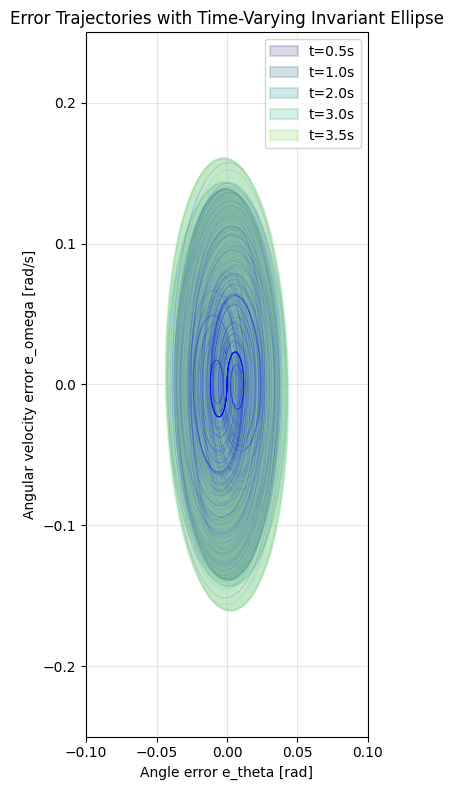

In [43]:
# Plot error trajectories with time-varying ellipse at specific times
# This shows the elliptical invariant set at several times overlaid with trajectories

fig, ax = plt.subplots(figsize=(8, 8))

# Plot all error trajectories
for traj in error_trajectories:
    ax.plot(traj[0], traj[1], 'b-', alpha=0.1, linewidth=0.5)

# Plot the time-varying ellipse at several times
dist = DISTURBANCE_BOUNDS['d']
plot_times = [0.5, 1.0, 2.0, 3.0, 3.5]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(plot_times)))

for t_plot, color in zip(plot_times, colors):
    M_t = eval_polynomial_metric(M_coefs_val, t_plot, times)
    M_t = 0.5 * (M_t + M_t.T)  # symmetrize
    M_proj = project_metric_2d(M_t, indices=(0, 1))
    # The ellipse is x^T M_proj x <= mu_phys * dist^2
    # Normalize: x^T (M_proj / (mu_phys * dist^2)) x <= 1
    M_normalized = M_proj / (mu_phys * dist**2)
    plot_ellipse(M_normalized, ax, label=f't={t_plot:.1f}s', color=color, alpha=0.2)

ax.set_xlim(-0.1, 0.1)
ax.set_ylim(-0.25, 0.25)
ax.set_xlabel('Angle error e_theta [rad]')
ax.set_ylabel('Angular velocity error e_omega [rad/s]')
ax.set_title('Error Trajectories with Time-Varying Invariant Ellipse')
ax.legend(loc='upper right')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/error_ellipse_times.png", dpi=150)
plt.show()

In [44]:
print("=== Summary ===")
print(f"Model: {ir.model_name}")
print(f"States: {ss.get_state_names()}")
print(f"Inputs: {ss.get_input_names()}")
print(f"Disturbance inputs: {disturbance_inputs}")
print(f"\nModel dynamics: {model_type}")
print(f"Error dynamics linear: {error_is_linear}")
print(f"\nPolytopic LMI Results:")
print(f"  Polytopic bound: theta ± {err_theta} rad")
print(f"  Number of time samples: {num_samples}")
print(f"  Optimal alpha: {alpha_star:.6f}")
print(f"  Optimal mu: {mu_star:.6f}")
print(f"  bounds_upper: {bounds_upper}")

=== Summary ===
Model: PendulumClosedLoop
States: ['theta', 'omega', 'xi']
Inputs: ['theta_ref', 'omega_ref', 'alpha_ref', 'u_ff', 'd']
Disturbance inputs: ['d']

Model dynamics: DynamicsClass.NONLINEAR
Error dynamics linear: False

Polytopic LMI Results:
  Polytopic bound: theta ± 0.1 rad
  Number of time samples: 20
  Optimal alpha: 0.936144
  Optimal mu: 10.396083
  bounds_upper: [0.04539912 0.16146206 0.16113416]
